<a href="https://colab.research.google.com/github/Kazuto-Takahashi/ML_practice/blob/main/08_chapter07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7章　多数決　(アンサンブル）
$
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\vt}[1]{{\boldsymbol #1}}
$


In [ ]:
# installされているパッケージの確認
!pip list

In [18]:
import numpy as np

<img src="https://drive.google.com/uc?export=view&id=11DQyiNrTkR051Qrm6t_Xmpo9UhSURvfE" width = 50%></img>


<img src="https://drive.google.com/uc?export=view&id=1XZagmR0Qa4uNcLpJfZSKc-pVz8VDRXOO" width = 50%></img>


<img src="https://drive.google.com/uc?export=view&id=1XYJp5rW5fQQYufGVfSdA68P10sFaTCB9" width = 50%></img>



In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
# 'versicolor' 'virginica' (data ID: 50-149)
# 'sepal width (cm)', 'petal length (cm)' (2nd and 3rd parameters)
X, y_org = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y_org) #yを0から昇順に。

In [3]:
print(f'type = {type(iris)}')
print(f'keys = {iris.keys()}')
#print(iris.data)
#print(iris.target)

type = <class 'sklearn.utils._bunch.Bunch'>
keys = dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [ ]:
for k, v in iris.items():
  print(k, v)

In [5]:
print(iris.data[0])
print(iris.target[0])
print(iris.target_names[0])
print(iris.feature_names)

[5.1 3.5 1.4 0.2]
0
setosa
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [6]:
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(100, 2)


In [7]:
print(y_org)
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.5, random_state = 1, stratify = y)

In [9]:
print(y_train)

[0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1
 1 0 1 0 0 1 1 0 0 1 0 0 0]


これらのデータに対していくつかの識別器を作って cross-validationで評価を行う。

'versicolor' 'virginica'  (data ID: 50-149)  
'sepal width (cm)', 'petal length (cm)' (2nd and 3rd parameters)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

# Logistic regression
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)

# Decision Tree
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

# Nearest neighbor
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

clf_labels = ['Logistic regression', 'Decision Tree', 'KNN']

In [11]:
# Decision Tree (clf2)以外には、データの前処理（標準化　StandardScalar()により0-mean 1-SD化）を行う
pipe1 = Pipeline([['sc', StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf',clf3]])

In [12]:
print('10-fold cross-validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print(f' AUC: {scores.mean():.3f} (+/- {scores.std():.3f}) [{label}]')

10-fold cross-validation:

 AUC: 0.917 (+/- 0.154) [Logistic regression]
 AUC: 0.867 (+/- 0.183) [Decision Tree]
 AUC: 0.850 (+/- 0.133) [KNN]


作成した3つの識別器を多数決でアンサンブルしてみる  


In [14]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
#from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
#import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [15]:
mv_clf = MajorityVoteClassifier(classifiers= [pipe1, clf2, pipe3])
clf_labels +=['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [19]:
print('10-fold cross-validation:\n')

for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print(f' AUC: {scores.mean():.3f} (+/- {scores.std():.3f}) [{label}]')

10-fold cross-validation:

 AUC: 0.917 (+/- 0.154) [Logistic regression]
 AUC: 0.867 (+/- 0.183) [Decision Tree]
 AUC: 0.850 (+/- 0.133) [KNN]
 AUC: 0.983 (+/- 0.050) [Majority voting]


未知のデータ(X_test: 残り半分）に対する性能の評価

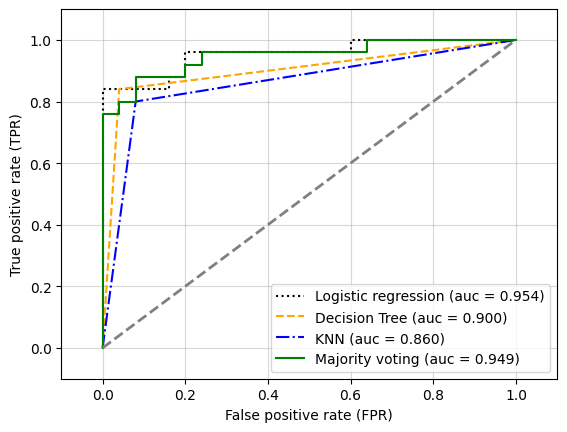

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

4つの2次元入力(sepal width がくの幅, petal length 花びらの長さ)の識別器の識別境界を可視化してみる。  
今回はすべての識別器で入力を標準化して比べる。  


In [ ]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

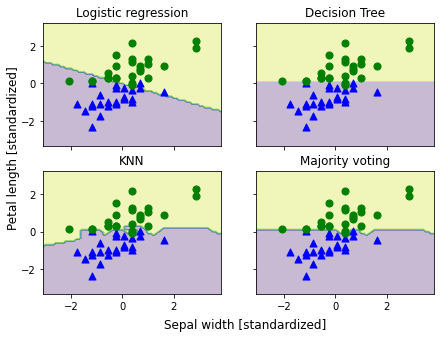

In [ ]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

アンサンブル識別器の決定境界は、他の識別器の掛け算のように見える。

-----


今の識別器のパラメータの確認  
これを使うと、各識別器にどんなパラメータがあるかわかる (tuningに使える）

get_param()は、
key   識別器の名前__パラメータ名  
value その値  

を返す。

In [ ]:
# 今の識別器のパラメータの確認
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'de

Decision Treeの（ハイパー）パラメータである、逆正則化パラメータ($C$)と、決定木の深さ（max_depth)のtuningを試みる  

10-fold cross validationに基づくGridSearchを使って探索する。

In [ ]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    #iid=False,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.3f %r"
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))

0.983 +/- 0.025 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.025 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.025 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.025 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


# Bagging （バギング）　Bootstrap aggregating  
(ブートストラップ集約）  

アンサンブル：  
アンサンブルを構成する個々の識別器が同じ訓練データを使う

**バギング：**  
アンサンブルを構成する個々の識別器が、**元のデータからランダムな復元抽出により得られるデータを使う（ブートストラップ標本）**

UCI Wineデータを用いて分類実験を行う  
1,2,3のクラスのうち、2,3のクラスのみ使う。  
特徴量として、'Alcohol', 'OD280/OD315 of diluted wines'　の2特徴量だけ使う　（1と12）  

In [ ]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)


In [ ]:
print(type(df_wine))
print(df_wine)

<class 'pandas.core.frame.DataFrame'>
     0      1     2     3     4    5   ...    8     9      10    11    12    13
0     1  14.23  1.71  2.43  15.6  127  ...  0.28  2.29   5.64  1.04  3.92  1065
1     1  13.20  1.78  2.14  11.2  100  ...  0.26  1.28   4.38  1.05  3.40  1050
2     1  13.16  2.36  2.67  18.6  101  ...  0.30  2.81   5.68  1.03  3.17  1185
3     1  14.37  1.95  2.50  16.8  113  ...  0.24  2.18   7.80  0.86  3.45  1480
4     1  13.24  2.59  2.87  21.0  118  ...  0.39  1.82   4.32  1.04  2.93   735
..   ..    ...   ...   ...   ...  ...  ...   ...   ...    ...   ...   ...   ...
173   3  13.71  5.65  2.45  20.5   95  ...  0.52  1.06   7.70  0.64  1.74   740
174   3  13.40  3.91  2.48  23.0  102  ...  0.43  1.41   7.30  0.70  1.56   750
175   3  13.27  4.28  2.26  20.0  120  ...  0.43  1.35  10.20  0.59  1.56   835
176   3  13.17  2.59  2.37  20.0  120  ...  0.53  1.46   9.30  0.60  1.62   840
177   3  14.13  4.10  2.74  24.5   96  ...  0.56  1.35   9.20  0.61  1.60   560

[

In [ ]:
# name each character
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [ ]:
print(df_wine.keys())

Index(['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')


In [ ]:
print(df_wine['Class label'])

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: Class label, Length: 178, dtype: int64


In [ ]:
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [ ]:
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3]


In [ ]:
# 先ほどと同様 2,3のクラスを1,2に変換
# 全データのうち2割をテストデータに。
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y,
                             test_size=0.2,
                             random_state=1,
                             stratify=y)

BaggingClassifierは、指定の数の(500個の）識別器（決定木）をアンサンブルし、異なるブートストラップ標本で学習させる。  

max_samples : 各識別器が学習する最大サンプル数　（float:割合）(baggingなら1.0以下）  
max_features: 各識別器が学習する最大特徴量の数　（float:割合）(baggingなら1.0)    
bootstrap   : bootstrapの有無：　重複を含むsamplingを許すか (baggingならTrue)  
bootstrap_features   : 重複を含む特徴のsamplingを許すか (baggingならFalse)  

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)

#　すべてのデータを重複を許して500本の木に学習させて多数決をしている。
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [ ]:
from sklearn.metrics import accuracy_score

# 普通のDecision Tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

# 500本のDecision TreeがBaggingされたモデル
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


--> 両方ともTrainに対しては精度100％達成している（max_depth=Noneとして無制限にしている  

Baggingしている方が、過学習を抑えている。

In [ ]:
# 500本の各Decision Treeが学習するデータの数を減らしてみる
# 今回の例では、減らしてもテストデータに対する（ほぼ）精度は変化しない
bag2 = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=0.1,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag2 = bag2.fit(X_train, y_train)
y_train_pred2 = bag2.predict(X_train)
y_test_pred2 = bag2.predict(X_test)

bag2_train = accuracy_score(y_train, y_train_pred2)
bag2_test = accuracy_score(y_test, y_test_pred2)
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag2_train, bag2_test))

Bagging train/test accuracies 0.926/0.917


test dataに対する決定境界の可視化

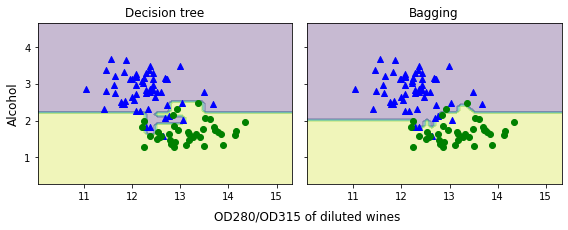

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

# AdaBoost (Adaptive Boosting)

ご分類された訓練データを後から弱識別器に学習させることでアンサンブルの性能を向上させる

Decision Tree　（max_depth=1）　500本をつかった例

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [ ]:
# 通常のDecision Tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

# 500本のAdaBoost
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


性能は向上しているが、AdaBoostでは、モデルのbiasは減っている（表現能力が増えている）が、varianceが増えている（過学習）  


決定境界の可視化

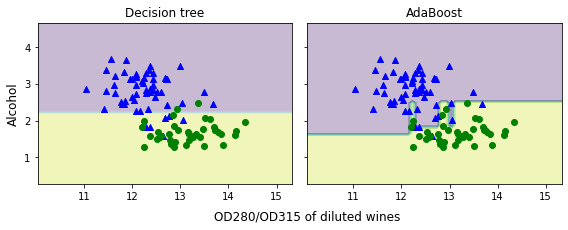

In [ ]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()